In [62]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, mape, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [45]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-02-01,0.092077
1,AAPL,2015-03-01,-0.027936
2,AAPL,2015-04-01,0.005770
3,AAPL,2015-05-01,0.040173
4,AAPL,2015-06-01,-0.033770
...,...,...,...
907,NVDA,2024-03-01,0.132893
908,NVDA,2024-04-01,-0.044700
909,NVDA,2024-05-01,0.238128
910,NVDA,2024-06-01,0.119427


In [46]:
Y_df['Z-Score'] = Y_df.groupby('unique_id')['y'].transform(lambda x: zscore(x, nan_policy='omit'))
data = Y_df[Y_df['unique_id'] == 'NVDA']
data

,unique_id,ds,y,Z-Score
798,NVDA,2015-02-01,0.138856,0.674413
799,NVDA,2015-03-01,-0.048740,-0.737406
800,NVDA,2015-04-01,0.058909,0.072743
801,NVDA,2015-05-01,-0.003158,-0.394365
802,NVDA,2015-06-01,-0.091099,-1.056200
...,...,...,...,...
907,NVDA,2024-03-01,0.132893,0.629537
908,NVDA,2024-04-01,-0.044700,-0.707002
909,NVDA,2024-05-01,0.238128,1.421521
910,NVDA,2024-06-01,0.119427,0.528191


In [47]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom

,unique_id,ds,y
0,AAPL,2015-02-01,0.092077
1,AAPL,2015-03-01,-0.027936
2,AAPL,2015-04-01,0.005770
3,AAPL,2015-05-01,0.040173
4,AAPL,2015-06-01,-0.033770
...,...,...,...
907,NVDA,2024-03-01,0.132893
908,NVDA,2024-04-01,-0.044700
909,NVDA,2024-05-01,0.238128
910,NVDA,2024-06-01,0.119427


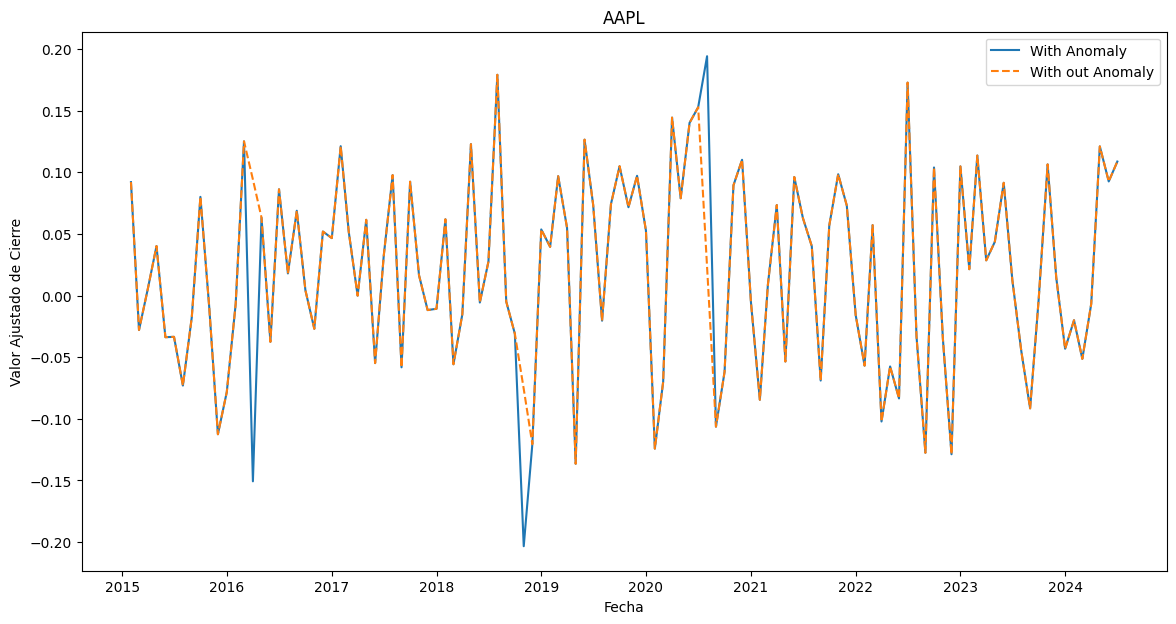

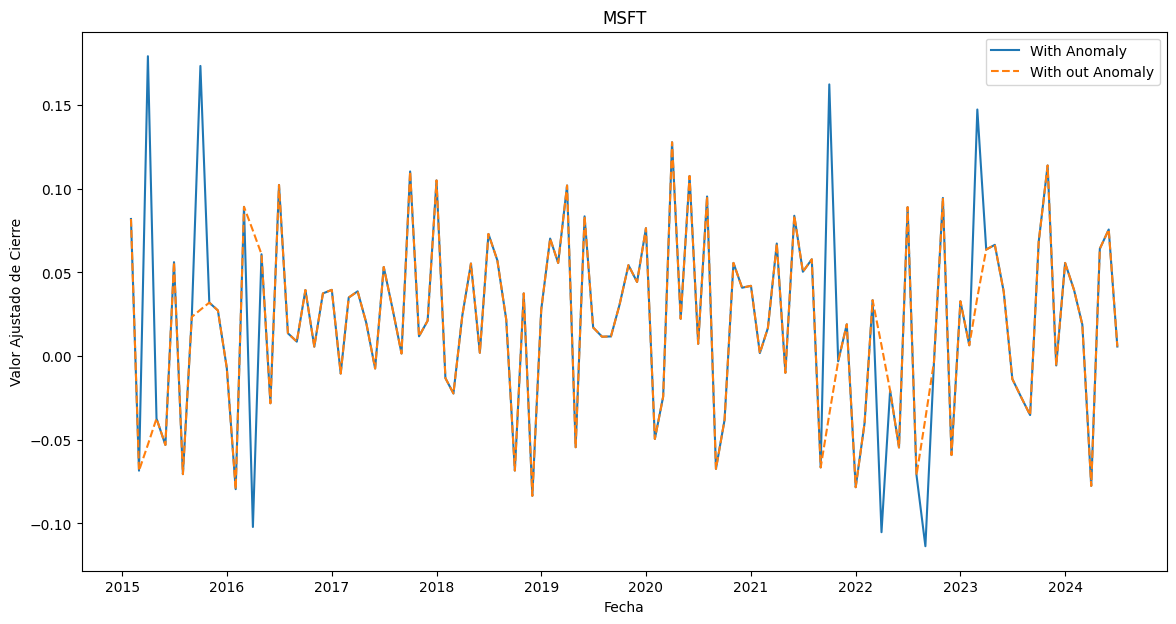

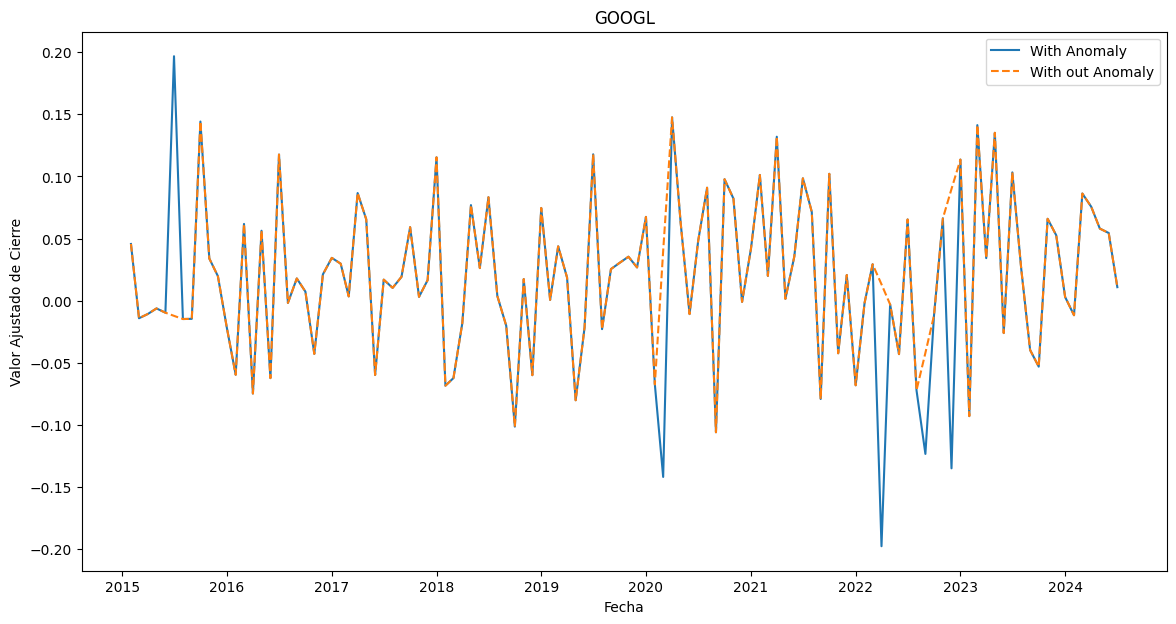

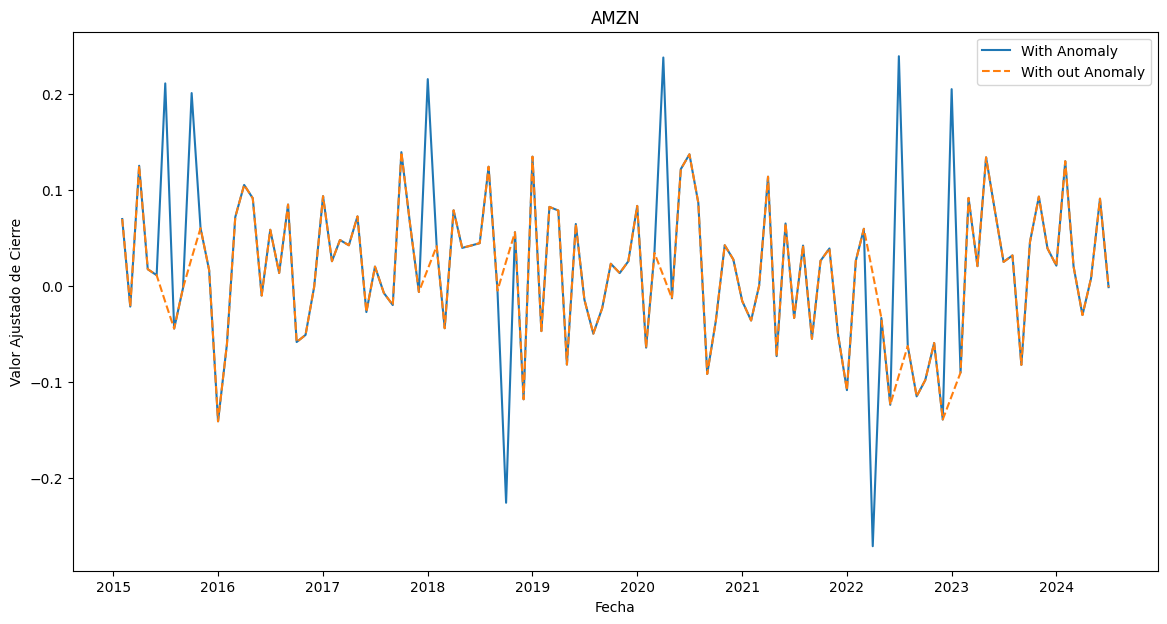

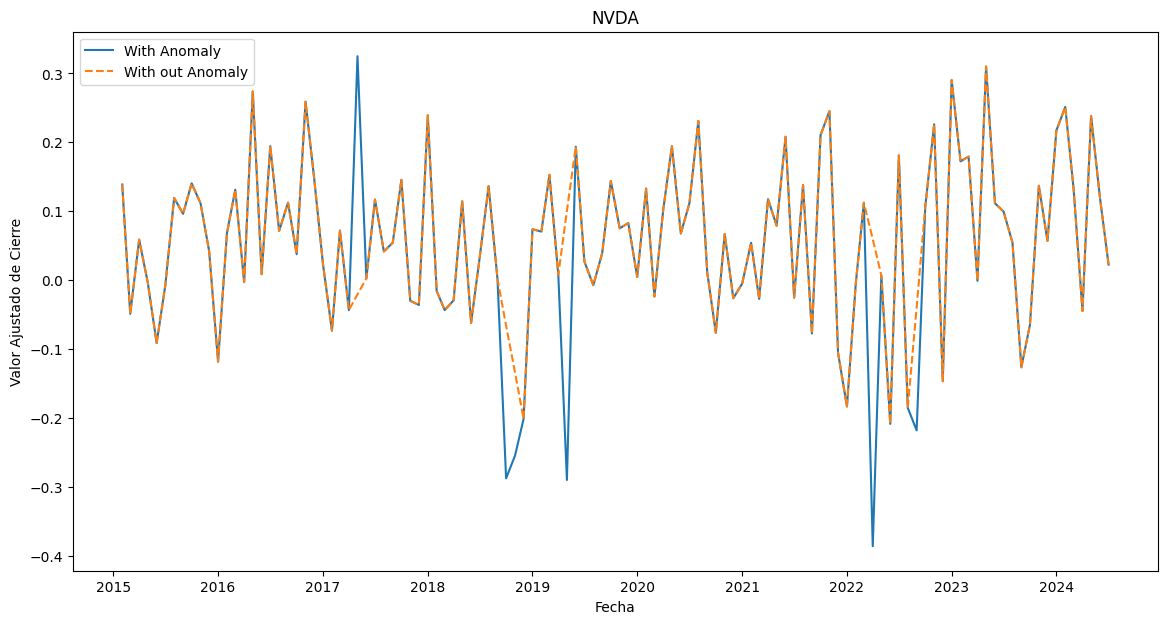

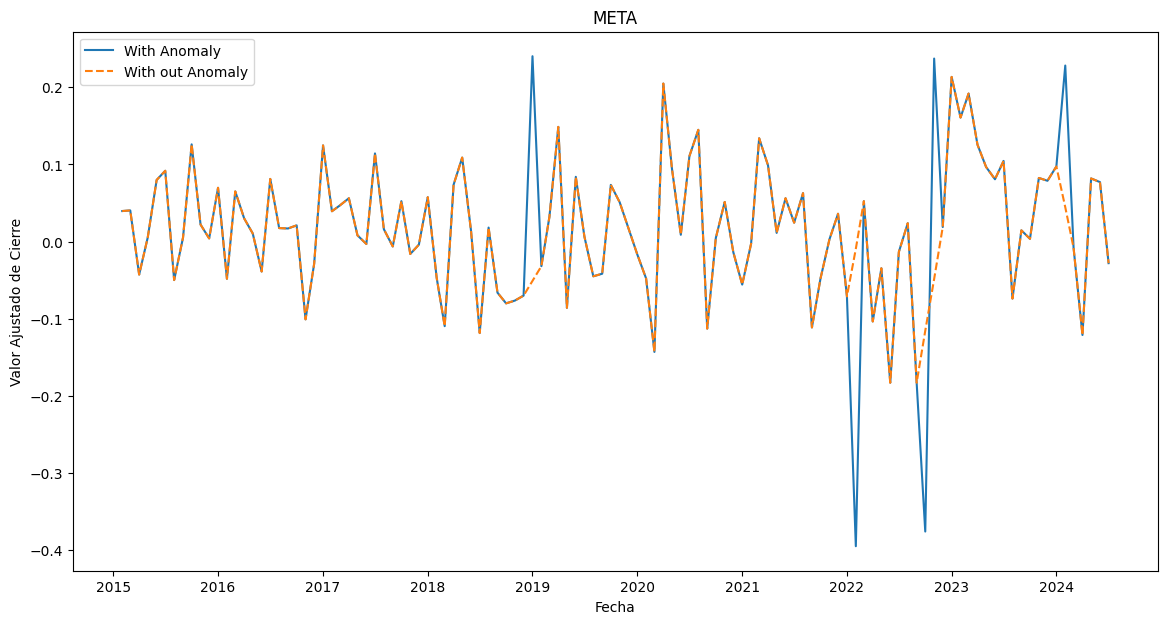

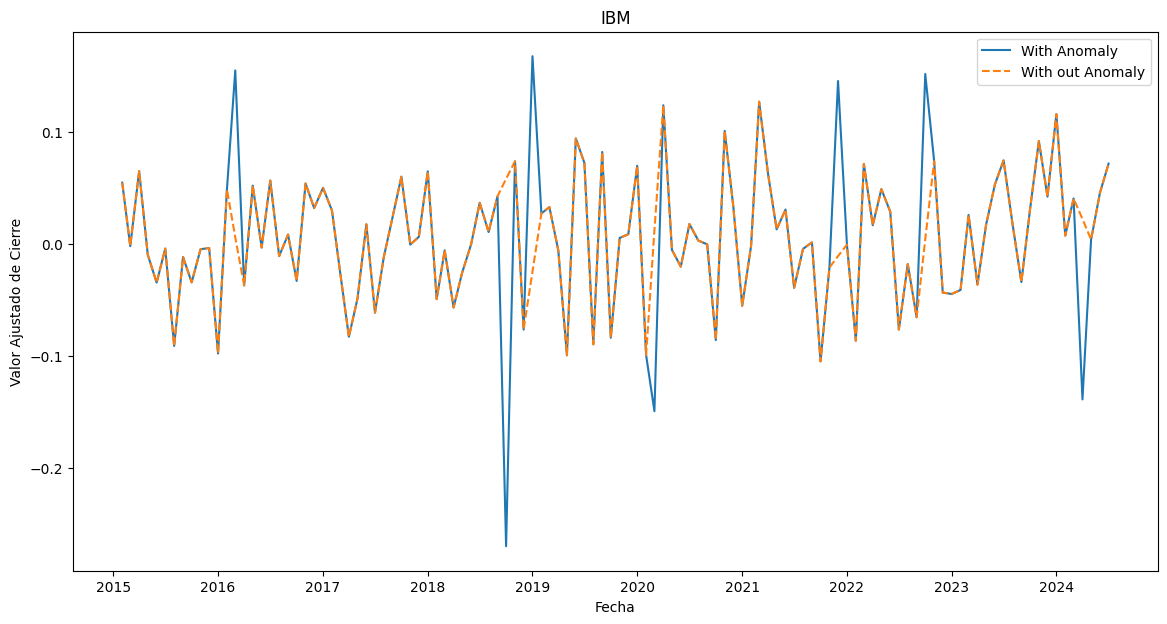

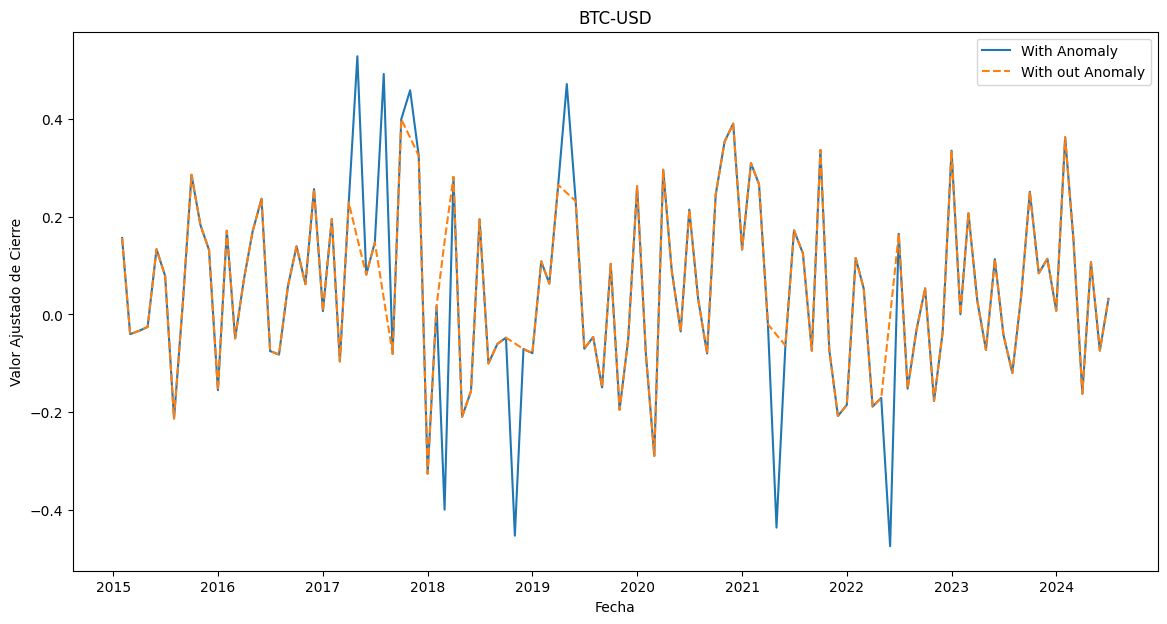

In [48]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()


In [49]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [50]:
season_length = 12 # Define season length as 12 months for monthly data
horizon = 1 # Forecast horizon is set to 1 month

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [51]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,,,
AAPL,2024-07-31,0.108764,-0.044658,0.021839,0.020994,0.029187,0.045689
AMZN,2024-07-31,-0.001191,0.031877,0.013141,0.015009,0.020363,0.011335
BTC-USD,2024-07-31,0.032050,-0.119742,0.011314,0.055644,0.048973,-0.056173
GOOGL,2024-07-31,0.010817,0.025662,0.005384,0.021194,0.036307,0.032033
IBM,2024-07-31,0.071722,0.018213,0.002615,0.005775,0.031745,-0.025525


In [52]:
cv_df = sf.cross_validation(df=ts_not_anom, h=horizon, n_windows=5, step_size=horizon, level=[95])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-95,Naive-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,AutoARIMA,...,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95,CES,CES-lo-95,CES-hi-95
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2024-03-01,2024-02-01,-0.051373,-0.019992,-0.220404,0.180419,0.113647,-0.093704,0.320998,-0.002807,...,0.145344,0.019555,-0.129610,0.168721,0.006825,-0.121497,0.159655,0.062214,-0.138703,0.255166
AAPL,2024-04-01,2024-03-01,-0.006729,-0.051373,-0.250950,0.148204,0.028575,-0.180286,0.237436,-0.008572,...,0.139175,0.018956,-0.130112,0.168023,0.001005,-0.127007,0.153465,0.048532,-0.157863,0.245378
AAPL,2024-05-01,2024-04-01,0.121059,-0.006729,-0.205572,0.192114,0.043647,-0.164273,0.251567,0.005066,...,0.152133,0.018681,-0.129767,0.167130,0.000232,-0.127182,0.151980,0.044873,-0.161884,0.236305
AAPL,2024-06-01,2024-05-01,0.092614,0.121059,-0.078308,0.320426,0.091525,-0.115909,0.298958,0.021015,...,0.168567,0.019718,-0.129287,0.168722,0.012315,-0.115991,0.165124,0.079119,-0.120523,0.277282
AAPL,2024-07-01,2024-06-01,0.108764,0.092614,-0.105931,0.291160,0.012704,-0.193700,0.219108,-0.007999,...,0.139480,0.020269,-0.128677,0.169215,0.020345,-0.108019,0.173223,0.102761,-0.092145,0.297412


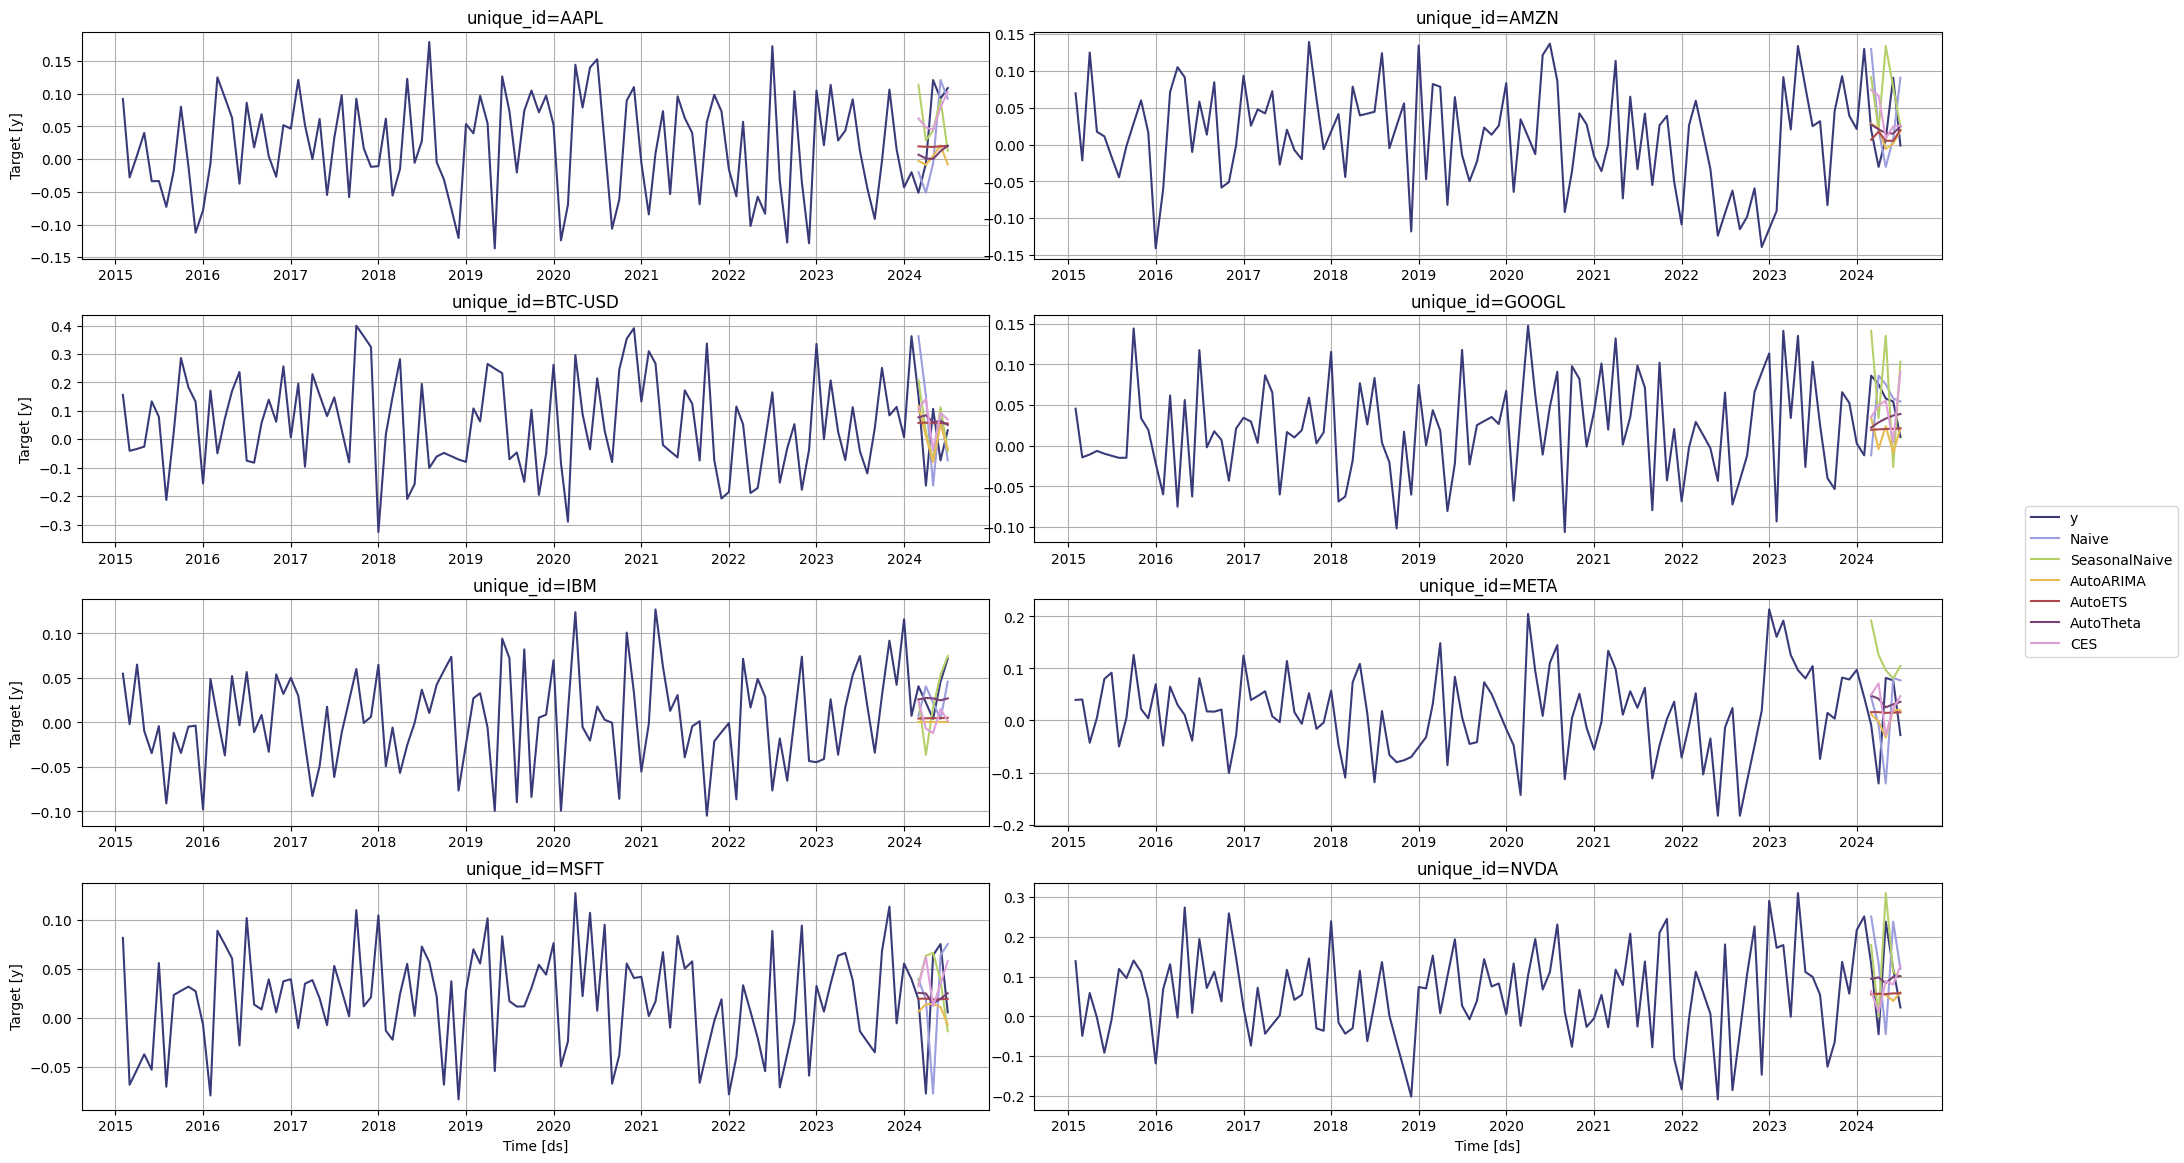

In [53]:
StatsForecast.plot(ts_not_anom, cv_df.drop(['cutoff', 'y'], axis=1))

In [54]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [63]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [64]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [65]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [66]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, mape, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-17 15:55:22,118 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b7b2f49da6501f9b39945b50451caac1 initialized by task ('shuffle-transfer-b7b2f49da6501f9b39945b50451caac1', 1) executed on worker tcp://127.0.0.1:50716
2024-07-17 15:55:26,247 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b7b2f49da6501f9b39945b50451caac1 deactivated due to stimulus 'task-finished-1721224526.244512'


,unique_id,cutoff,metric,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
0,AAPL,2024-05-01,mse,0.000809,0.000001,0.005126,0.005314,0.006448,0.000182
1,AAPL,2024-05-01,mae,0.028444,0.00109,0.071599,0.072897,0.0803,0.013496
2,AAPL,2024-05-01,mape,30.712818,1.176695,77.308693,78.709862,86.7033,14.571783
3,AAPL,2024-05-01,smape,26.624287,1.183659,126.021454,129.78772,153.055298,15.716898
4,BTC-USD,2024-04-01,mse,0.072664,0.032285,0.0348,0.002538,0.002217,0.021505
...,...,...,...,...,...,...,...,...,...
15,META,2024-06-01,smape,200.0,200.0,200.0,200.0,200.0,200.0
16,NVDA,2024-06-01,mse,0.009365,0.005926,0.001429,0.001276,0.006193,0.010985
17,NVDA,2024-06-01,mae,0.096774,0.076982,0.037797,0.035714,0.078694,0.104808
18,NVDA,2024-06-01,mape,427.220001,339.844238,166.860123,157.664963,347.403503,462.686157


In [67]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  SeasonalNaive   AutoARIMA     AutoETS  \
cutoff     metric                                                       
2024-02-01 mae        0.084235       0.077898    0.037064    0.048043   
           mape     221.625732     418.963287   86.248825    98.70256   
           mse        0.010609       0.010124    0.001848    0.003312   
           smape    123.268379      92.524223  113.699631  120.410515   
2024-03-01 mae        0.103346       0.101004    0.080138    0.088018   
           mape     217.007019     201.484955  119.236305  161.896454   
           mse         0.01978       0.015978    0.009062    0.011739   
           smape    149.960434     183.499908  177.114059  180.852615   
2024-04-01 mae        0.137406       0.070305    0.087837    0.061056   
           mape     239.397934     286.364746  111.804001   60.657623   
           mse        0.029047       0.008205    0.012377    0.006762   
           smape    170.832382      90.377411  165.045319   92.607307   
2024-05-01 mae        0.059089       0.042236    0.074782     0.06798   
           mape       73.15213      61.649582   98.632294   88.416481   
           mse        0.007059       0.005394    0.006141    0.005426   
           smape     82.162224       63.54015  160.640244   135.13736   
2024-06-01 mae        0.069465       0.065066    0.047943    0.037989   
           mape    1318.556519     567.487793  344.609497  334.950958   
           mse        0.005985       0.005975    0.003435    0.002095   
           smape    137.739944     156.265701  169.846375  128.449661   

                    AutoTheta         CES  
cutoff     metric                          
2024-02-01 mae       0.040133    0.052805  
           mape    130.930374  180.128448  
           mse       0.002271    0.003649  
           smape    90.283569  101.146988  
2024-03-01 mae       0.095823    0.112467  
           mape    138.488586   244.62941  
           mse       0.015439    0.020843  
           smape   163.834106  180.116699  
2024-04-01 mae       0.060435    0.069129  
           mape    135.354248  111.657043  
           mse        0.00593    0.008086  
           smape   106.156113  116.245834  
2024-05-01 mae       0.056918    0.057644  
           mape      73.22438   78.591064  
           mse       0.004732    0.005254  
           smape   101.820724  102.650803  
2024-06-01 mae       0.046051    0.056594  
           mape    446.954346  608.187012  
           mse       0.002788    0.004102  
           smape   129.871506  141.473297

<Axes: xlabel='error', ylabel='model'>

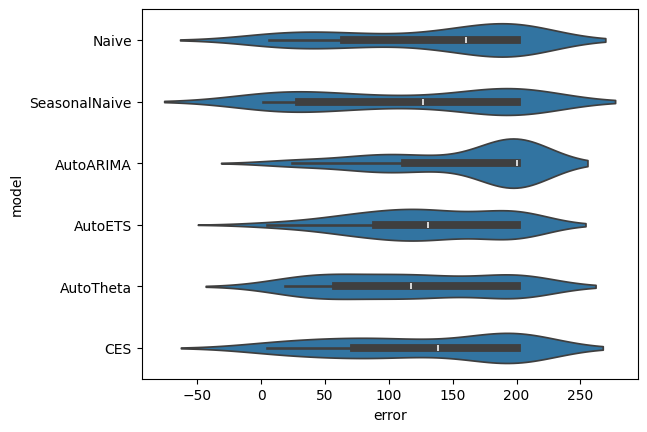

In [68]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

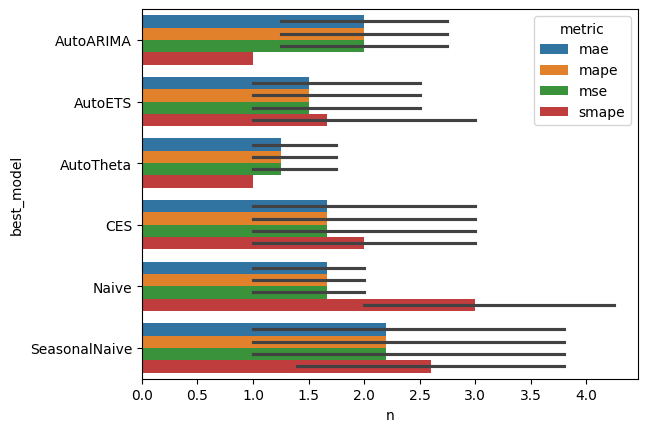

In [69]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')